In [114]:
import os,sys
import datetime
import scanpy as sc 
from time import time

In [101]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath('utility_functions'))

from rz_import_statements import *
import rz_functions as rz

In [102]:
import ng_functions as ng

## Load ImmGen

In [123]:
# ImmGen references profiles were downloaded from Table S7 from Zilionis et al., 2019:
# https://ars.els-cdn.com/content/image/1-s2.0-S1074761319301268-mmc7.zip
# Preprocessed immgen data, code for preprocessing, and classifier code also available on github:
# rapolaszilionis/bayesian_classifier
immgen = pd.read_excel('./Table_S7.xlsx', sheet_name = 1, index_col = 0, skiprows = 3)

In [124]:
immgen

SC_LTSL_BM  SC_STSL_BM  SC_LTSL_FL  SC_STSL_FL  SC_MPP34F_BM  \
0610007C21Rik       61.99       72.90       82.54       74.85         80.91   
0610007L01Rik      104.46      102.38      108.72      108.72        104.42   
0610007P08Rik       42.72       41.12       43.03       43.13         40.82   
0610007P14Rik      101.31       90.87       87.62       82.79        156.21   
0610007P22Rik       33.83       40.92       39.55       39.56         49.15   
...                   ...         ...         ...         ...           ...   
Zzef1               84.03       75.62       67.37       71.03         50.76   
Zzz3               182.49      144.85      198.43      158.70        128.37   
a                   20.17       20.14       19.45       18.82         20.85   
l7Rn6               42.86       47.96       63.54       67.80        119.10   
rp9                104.91      101.60       91.84       71.67         70.89   

               SC_ST34F_BM  SC_CMP_BM_DR  SC_MEP_BM  SC_GMP_BM  SC_CDP_BM  \
0610007C21Rik        76.30         86.65      64.56     132.78     114.41   
0610007L01Rik       111.69        139.07     141.16     220.25     135.14   
0610007P08Rik        39.60         45.56      54.03      27.12      33.56   
0610007P14Rik       168.35        175.47     154.39     192.41     146.51   
0610007P22Rik        49.88         50.21      61.81      76.95      46.06   
...                    ...           ...        ...        ...        ...   
Zzef1                56.32         72.50      59.91      45.83      62.83   
Zzz3                145.25        143.13     116.55      53.34      90.28   
a                    19.09         18.94      21.56      22.60      22.65   
l7Rn6               107.09        123.55     127.18      86.96      94.14   
rp9                  69.08         71.19      97.78      89.00      57.50   

               ...  EO_AT_v2  Eo_BL_v2   MC_Tr   MC_To   MC_Sk   MC_PC  \
0610007C21Rik  ...     72.39     49.81  113.40   95.43  107.02  158.87   
0610007L01Rik  ...    126.39     91.14  182.37  188.27  184.97  153.00   
0610007P08Rik  ...     19.18     19.98  183.67  136.28  117.68  101.15   
0610007P14Rik  ...    102.26    142.63  204.67  113.62  117.47  271.84   
0610007P22Rik  ...     25.67     31.34   27.62   29.56   26.18   25.26   
...            ...       ...       ...     ...     ...     ...     ...   
Zzef1          ...     87.68    110.02   88.96   89.14   78.89   87.05   
Zzz3           ...     83.69     90.40  114.99   99.80  135.94  124.00   
a              ...     21.02     19.24   18.68   20.37   20.06   18.99   
l7Rn6          ...     37.19     74.93   50.38   44.16   40.48   87.29   
rp9            ...     48.83     74.48   36.45   32.66   34.47   54.84   

                MC_Es  MC_digest_PC   BA_Sp   BA_Bl  
0610007C21Rik  107.52        187.15   98.70  102.66  
0610007L01Rik  200.19        155.20  140.11  130.30  
0610007P08Rik  137.80        127.14   48.35   50.19  
0610007P14Rik  163.49        238.58  125.82  127.62  
0610007P22Rik   30.25         25.43   36.81   33.90  
...               ...           ...     ...     ...  
Zzef1           82.33         74.10  111.06  122.27  
Zzz3           117.47        121.97   88.50   84.67  
a               20.44         19.51   19.75   20.07  
l7Rn6           54.92         84.65   78.20   62.74  
rp9             28.89         53.87   78.59   61.51  

[21755 rows x 276 columns]

In [125]:
# Check whether you need to add a pseudo count 
# Pseudo count was already added 
immgen.min()

SC_LTSL_BM      10.98
SC_STSL_BM      10.98
SC_LTSL_FL      10.98
SC_STSL_FL      10.98
SC_MPP34F_BM    10.98
                ...  
MC_PC           10.98
MC_Es           10.98
MC_digest_PC    10.98
BA_Sp           10.98
BA_Bl           10.98
Length: 276, dtype: float64

In [126]:
# which are the classes to consider?
class_to_consider = immgen.columns #all

# decide on which class to exclude, more detailed annotation available at immgen.org
# http://rstats.immgen.org/DataRequest/

excl = [i for i in class_to_consider if\
        # all stromal
        (i.upper().startswith('MECHI_'))|\
        (i.upper().startswith('EP_'))|\
        (i.upper().startswith('FI_'))|\
        (i.upper().startswith('FRC_'))|\
        (i.upper().startswith('LEC_'))|\
        (i.upper().startswith('BEC_'))|\
        (i.upper().startswith('ST_'))|\
        (i.upper().startswith('DN_'))|\
        
        # all stem cells 
        (i.upper().startswith('SC'))|\
        
        # all non-relevant residential macrophages 
        (i == 'MF_103-11b+_Lu')|\
        (i == 'MF_103-11b+_Salm3_SI')|\
        (i == 'MF_103-11b+_SI')|\
        (i == 'MF_11cloSer_SI')|\
        (i == 'MF_11cloSer_Salm3_SI')|\
        (i == 'MF_Lu')|\
        (i == 'MF_Medl_SLN')|\
        (i == 'MF_Microglia_CNS')|\
        (i == 'MF_PPAR-_Lu')|\
        (i == 'MF_RP_Sp')|\
        (i == 'MF_11c-11b+_Lu')|\
        (i == 'MF_Alv_Lu')|\
        (i == 'MF_AT_v2')|\
        (i == 'MF_F480hi_ctrl_PC')|\
        (i == 'MF_F480hi_Gata6ko_PC')
       ]

print(excl)

# overwrite class_to_consider
class_to_consider = [i for i in class_to_consider if i not in excl]
print(class_to_consider)

['SC_LTSL_BM', 'SC_STSL_BM', 'SC_LTSL_FL', 'SC_STSL_FL', 'SC_MPP34F_BM', 'SC_ST34F_BM', 'SC_CMP_BM_DR', 'SC_MEP_BM', 'SC_GMP_BM', 'SC_CDP_BM', 'SC_MDP_BM', 'MF_103-11b+_Lu', 'MF_103-11b+_Salm3_SI', 'MF_103-11b+_SI', 'MF_11cloSer_SI', 'MF_11cloSer_Salm3_SI', 'MF_Lu', 'MF_Medl_SLN', 'MF_Microglia_CNS', 'MF_PPAR-_Lu', 'MF_RP_Sp', 'Ep_MEChi_Th', 'Fi_MTS15+_Th', 'Fi_Sk', 'FRC_MLN', 'FRC_SLN', 'FRC_SLN_OT', 'LEC_MLN', 'LEC_SLN', 'LEC_SLN_OT', 'BEC_MLN', 'BEC_SLN', 'BEC_SLN_OT', 'St_31-38-44-_SLN', 'MF_11c-11b+_Lu', 'MF_Alv_Lu', 'MF_AT_v2', 'MF_F480hi_ctrl_PC', 'MF_F480hi_Gata6ko_PC', 'DN_SLN_CFA_d6_v2', 'DN_SLN_v2', 'Ep_5wk_MEC_Sca1+_Th', 'Ep_5wk_MEChi_Th', 'Ep_5wk_MEClo_Th', 'Ep_8wk_CEC_Sca1+_Th', 'Ep_8wk_CEChi_Th', 'Ep_8wk_MEChi_Th', 'Ep_8wk_MEClo_Th', 'FRC_Cad11_WT_v2', 'FRC_SLN_CFA_d6_v2', 'FRC_SLN_v2', 'LEC_SLN_CFA_d6_v2', 'LEC_SLN_v2', 'MEChi_GFP-_Adult', 'MEChi_GFP+_Adult', 'MEChi_GFP+_Adult_KO']
['MLP_BM', 'MLP_FL', 'proB_CLP_BM', 'proB_CLP_FL', 'proB_FrA_BM', 'proB_FrA_FL', 'proB_Fr

In [127]:
# Exclude stromal classes 
smask = immgen.columns.isin(class_to_consider)
print(immgen.shape, smask.sum(), (1-smask).sum())
immgen = immgen.loc[:, smask]
print(immgen.shape)

(21755, 276) 220 56
(21755, 220)


## Load adata

In [128]:
adata = sc.read_h5ad('tox_marie_all_cells_unnormalized_pca_umap_leiden_35358x22631_backup_200420_17h58.h5ad')

In [129]:
# Sum Il12b and eYFP + normalize to 10,000 counts 
adata[:,['Il12b']].X = adata[:,['Il12b', 'eYFP']].X.sum(1)
adata[:,['eYFP']].X = 0

sc.pp.normalize_total(adata, target_sum=1e4)

In [130]:
# Filter out predicted doublets 
cmask = adata.obs['predicted_doublet'] == False
print(adata.shape, cmask.sum(), adata.shape[0] - cmask.sum())
adata = adata[cmask, :]
print(adata.shape)

(35358, 22631) 34686 672
(34686, 22631)


In [131]:
# Check that the index of adata.obs is not duplicated 
# Index is not duplicated 
print(adata.obs.index.duplicated().sum())

0


## Run naive bayesian classifier 

In [132]:
# Subset on overlapping genes 
gmask = np.in1d(adata.var_names, immgen.index)
print(adata.shape, immgen.shape, gmask.sum(), len(gset))
gset = adata.var_names[gmask]
adata = adata[:, gset] 
immgen = immgen.loc[gset, :]
print(adata.shape, immgen.shape)

(34686, 22631) (21755, 220) 17640 17640
(34686, 17640) (17640, 220)


In [133]:
# Run bayesian_classifier 

start = time()
bays = []
i = 0
step=5000  
comment = 'immgen_to_tox'
for j in range(step,adata.shape[0]+step,step):
        
    j = min(j,adata.shape[0])
    tmp_dense = pd.DataFrame(adata.X.T[:,i:j].todense())
    tmp_dense.index = np.array(adata.var_names)
    tmp_dense.columns = adata.obs.index.values[i:j]
    
    bay = rz.bayesian_classifier(tmp_dense, immgen)
    bays.append(bay)
    i0 = i
    i = j
    
    print('%.2f min.'%((time()-start)/60.))
    print('cells from %d to %d done'%(i0,j))

# conenate
bay = pd.concat(bays,axis=1)

fname = 'backups/loglikelihoods_bay_classif_%s_%s'%(comment,rz.now())
print(fname)
rz.save_df(bay,fname)

3.04 min.
cells from 0 to 5000 done
5.97 min.
cells from 5000 to 10000 done
8.90 min.
cells from 10000 to 15000 done
11.93 min.
cells from 15000 to 20000 done
15.03 min.
cells from 20000 to 25000 done
18.27 min.
cells from 25000 to 30000 done
21.51 min.
cells from 30000 to 34686 done
backups/loglikelihoods_bay_classif_immgen_to_tox_200421_15h20


In [134]:
bay

48-pool1      98-pool1     237-pool1     246-pool1  \
MLP_BM       -36629.674009 -36875.610059 -34256.285885 -33849.689537   
MLP_FL       -36675.521108 -38279.477455 -34569.662773 -34073.641693   
proB_CLP_BM  -36798.046227 -35099.264420 -34162.838452 -33703.062878   
proB_CLP_FL  -36829.748290 -37959.119794 -34589.956400 -34181.781117   
proB_FrA_BM  -36747.471909 -35553.599636 -34123.590246 -33737.630220   
...                    ...           ...           ...           ...   
MC_PC        -36721.057098 -37929.679963 -35151.024705 -35278.252312   
MC_Es        -36665.360753 -37152.278914 -35096.181401 -34879.992414   
MC_digest_PC -36696.950591 -37585.746205 -35005.175498 -35080.587110   
BA_Sp        -36566.292425 -36094.288817 -34339.466498 -33918.004323   
BA_Bl        -36717.696858 -35872.875177 -34551.695852 -34206.403082   

                 342-pool1     533-pool1     879-pool1     904-pool1  \
MLP_BM       -31107.704835 -35261.953701 -36595.218286 -33202.051486   
MLP_FL       -31178.563976 -35354.808657 -37288.595085 -33460.631487   
proB_CLP_BM  -31282.831652 -35308.438861 -35435.659476 -33153.243427   
proB_CLP_FL  -31384.940589 -35510.328045 -37291.141543 -33490.814989   
proB_FrA_BM  -31365.547628 -35196.896088 -35592.382201 -33136.412980   
...                    ...           ...           ...           ...   
MC_PC        -34028.453036 -35625.616182 -37107.964354 -34036.248657   
MC_Es        -33763.476791 -35389.067229 -36071.759694 -33801.375984   
MC_digest_PC -33814.278805 -35467.583268 -36424.494734 -33796.356805   
BA_Sp        -32153.368639 -34880.404604 -35614.138265 -33012.184335   
BA_Bl        -32922.485386 -35092.401023 -35406.345263 -33213.427577   

                1103-pool1    1157-pool1  ...  1468698-pool5  1469164-pool5  \
MLP_BM       -34743.789688 -36279.222233  ...  -35770.671917  -36343.593209   
MLP_FL       -35487.110158 -36362.584087  ...  -36035.836140  -36488.890644   
proB_CLP_BM  -33911.851613 -36458.405038  ...  -35626.154545  -36279.810746   
proB_CLP_FL  -35487.606942 -36524.388848  ...  -36116.220496  -36580.299757   
proB_FrA_BM  -34104.496406 -36452.867190  ...  -35549.834347  -36183.848663   
...                    ...           ...  ...            ...            ...   
MC_PC        -35152.030887 -36910.769242  ...  -36012.626418  -36615.120320   
MC_Es        -34367.655652 -36734.980327  ...  -35641.720485  -36322.812824   
MC_digest_PC -34787.322463 -36845.142785  ...  -35796.231113  -36464.673192   
BA_Sp        -34197.000678 -36547.482767  ...  -35377.562446  -35878.322214   
BA_Bl        -34054.107927 -36731.753781  ...  -35426.655800  -36044.114508   

              1469818-pool5  1470383-pool5  1471336-pool5  1471700-pool5  \
MLP_BM        -31027.499024  -34131.287822  -32314.169329  -34786.141899   
MLP_FL        -31317.854969  -34278.742788  -32094.825262  -34950.194266   
proB_CLP_BM   -30947.071718  -34006.914862  -32554.399450  -34759.522386   
proB_CLP_FL   -31402.841958  -34329.314848  -32272.556522  -35056.158550   
proB_FrA_BM   -30944.134904  -33939.142226  -32588.067160  -34741.571173   
...                     ...            ...            ...            ...   
MC_PC         -31435.829106  -34413.489214  -34558.920413  -35339.325842   
MC_Es         -31076.905885  -34254.416948  -34465.584171  -35068.805798   
MC_digest_PC  -31221.848340  -34317.683590  -34345.167755  -35270.627824   
BA_Sp         -30887.940504  -33697.100317  -34084.614157  -34482.389998   
BA_Bl         -30932.980263  -33868.031930  -34467.896499  -34648.004152   

              1471869-pool5  1472549-pool5  1472953-pool5  1472972-pool5  
MLP_BM        -35415.972832  -34176.665458  -35380.393427  -35040.749420  
MLP_FL        -35705.133393  -34125.667685  -35441.925908  -35209.020339  
proB_CLP_BM   -35298.275603  -34308.738600  -35358.401690  -34903.399864  
proB_CLP_FL   -35765.002347  -34338.537095  -35584.301247  -35454.198779  
proB_FrA_BM   -35299.838045  -34270.021449  -35315.

In [135]:
# I have results of the bayesian classifier. They are log10 probabilities.
bay = bay-bay.max()

# find max value:
themax = bay.max().max()
print(themax)

# go from log-probabilities to probabilities
base = 10.
print(base**themax)

#get probabilities
bay = base**bay

#make probabilities sum to 1
bay = bay/bay.sum()

# Tranpose for the purpose of adding the Leiden cluster column
bay = bay.T

# You can never check the order enough when using a classifier: 
m = bay.index == adata.obs.index
print(all(m))

# Add the MAP ImmGen class for each cell
adata.obs['immgen_cell'] = bay.idxmax(axis = 1)

# Add the Leiden cluster column from the adata.obs
bay = bay.join(adata.obs['leiden'])

# For each Leiden cluster calculate the mean Likelihood for each ImmGen class 
meanBay = bay.groupby('leiden').mean().T  

0.0
1.0


Trying to set attribute `.obs` of view, copying.


True


In [136]:
meanBay.idxmax(axis = 0)

leiden
0             GN_Thio_PC
1           Mo_6C+II-_LN
2           Mo_6C+II-_LN
3        DC_8-4-11b-_SLN
4             GN_Thio_PC
5        DC_8-4-11b-_SLN
6              T_8Nve_LN
7                 B1a_Sp
8     MF_480int_LV_Naive
9        DC_8-4-11b-_SLN
10     MF_480hi_LV_Naive
11          NK_DAP10-_Sp
12       DC_8-4-11b-_SLN
13                B1a_Sp
14          NK_DAP10-_Sp
15          GN_Arth_SynF
16          Mo_6C+II-_LN
17          Mo_6C+II-_LN
18          DC_pDC_8-_Sp
19         T_4FP3+25+_Sp
20          GN_Arth_SynF
21            GN_Arth_BM
22    MF_480int_LV_Naive
23          Mo_6C+II-_LN
24                 BA_Bl
25                B1a_Sp
26        Mo_6C-IIint_Bl
27    MF_480int_LV_Naive
28       DC_8-4-11b-_SLN
29       DC_8-4-11b-_SLN
30        MF_II-480hi_PC
dtype: object

In [137]:
# Add immgen_leiden to adata.obs 
adata.obs['immgen_leiden'] = [meanBay.idxmax(axis = 0)[leiden] for leiden in adata.obs['leiden']]

In [138]:
adata.obs

barcode   group           library_name  \
48-pool1       AAACAAACAGAGGATAAGACACCA       B     Liver_CD45pos_NT_B   
98-pool1       AAACAAACAGAGGATACAATACTT       B     Liver_CD45pos_NT_B   
237-pool1      AAACAAACAGAGGATAGGCCCTTA       B     Liver_CD45pos_NT_B   
246-pool1      AAACAAACAGAGGATAGGGAGGTA       B     Liver_CD45pos_NT_B   
342-pool1      AAACAAACAGAGGATATGGCTACC       B     Liver_CD45pos_NT_B   
...                                 ...     ...                    ...   
1471700-pool5  TGTTATCAAGGCTTAGGATTTACC  J_rep2  Liver_IL12_Trx_J_rep2   
1471869-pool5  TGTTATCAAGGCTTAGTTTATCAC  J_rep2  Liver_IL12_Trx_J_rep2   
1472549-pool5  TGTTATCAATTAGACGTACTTGTG       K       Liver_IL12_Trx_K   
1472953-pool5  TGTTATCACGGAGAGATCCTTATT  I_rep2  Tumor_IL12_Trx_I_rep2   
1472972-pool5  TGTTATCACGGAGAGATGATGCCC  I_rep2  Tumor_IL12_Trx_I_rep2   

                marker  max_mt  min_tot  mito_frac      n_counts  n_genes  \
48-pool1       CD45pos    0.15      200   0.040964  10000.000977      348   
98-pool1       CD45pos    0.15      200   0.005613  10000.000000      581   
237-pool1      CD45pos    0.15      200   0.035451  10000.001953      470   
246-pool1      CD45pos    0.15      200   0.018000  10000.000000      374   
342-pool1      CD45pos    0.15      200   0.035088  10000.000000      318   
...                ...     ...      ...        ...           ...      ...   
1471700-pool5     IL12    0.15      250   0.050179  10000.000000      215   
1471869-pool5     IL12    0.15      250   0.043726  10000.000000      550   
1472549-pool5     IL12    0.15      400   0.023161  10000.000977      438   
1472953-pool5     IL12    0.15      300   0.022010   9999.999023      785   
1472972-pool5     IL12    0.15      300   0.040307  10000.000977      631   

                pool tissue treatment leiden  doublet_score  \
48-pool1       pool1  Liver        NT      8       0.007103   
98-pool1       pool1  Liver        NT     20       0.014590   
237-pool1      pool1  Liver        NT     11       0.016036   
246-pool1      pool1  Liver        NT     16       0.027342   
342-pool1      pool1  Liver        NT      6       0.007778   
...              ...    ...       ...    ...            ...   
1471700-pool5  pool5  Liver       Trx      5       0.112767   
1471869-pool5  pool5  Liver       Trx      5       0.018651   
1472549-pool5  pool5  Liver       Trx      3       0.028492   
1472953-pool5  pool5  Tumor       Trx      3       0.014825   
1472972-pool5  pool5  Tumor       Trx      2       0.013672   

               predicted_doublet         immgen_cell       immgen_leiden  
48-pool1                   False  MF_480int_LV_Naive  MF_480int_LV_Naive  
98-pool1                   False               GN_Bl        GN_Arth_SynF  
237-pool1                  False        NK_DAP10-_Sp        NK_DAP10-_Sp  
246-pool1                  False        Mo_6C+II-_LN        Mo_6C+II-_LN  
342-pool1                  False           T_8Nve_LN           T_8Nve_LN  
...                          ...                 ...                 ...  
1471700-pool5              False     DC_8-4-11b-_SLN     DC_8-4-11b-_SLN  
1471869-pool5              False     DC_8-4-11b-_SLN     DC_8-4-11b-_SLN  
1472549-pool5              False     DC_8-4-11b-_SLN     DC_8-4-11b-_SLN  
1472953-pool5              False     DC_8-4-11b-_MLN     DC_8-4-11b-_SLN  
1472972-pool5              False   DC_103-11b+24+_Lu        Mo_6C+II-_LN  

[34686 rows x 17 columns]

## Color UMAP embedding by each ImmGenn class (i.e. high ImmGen class resolution)

... storing 'immgen_cell' as categorical
... storing 'immgen_leiden' as categorical


[<Figure size 6870x2000 with 2 Axes>]

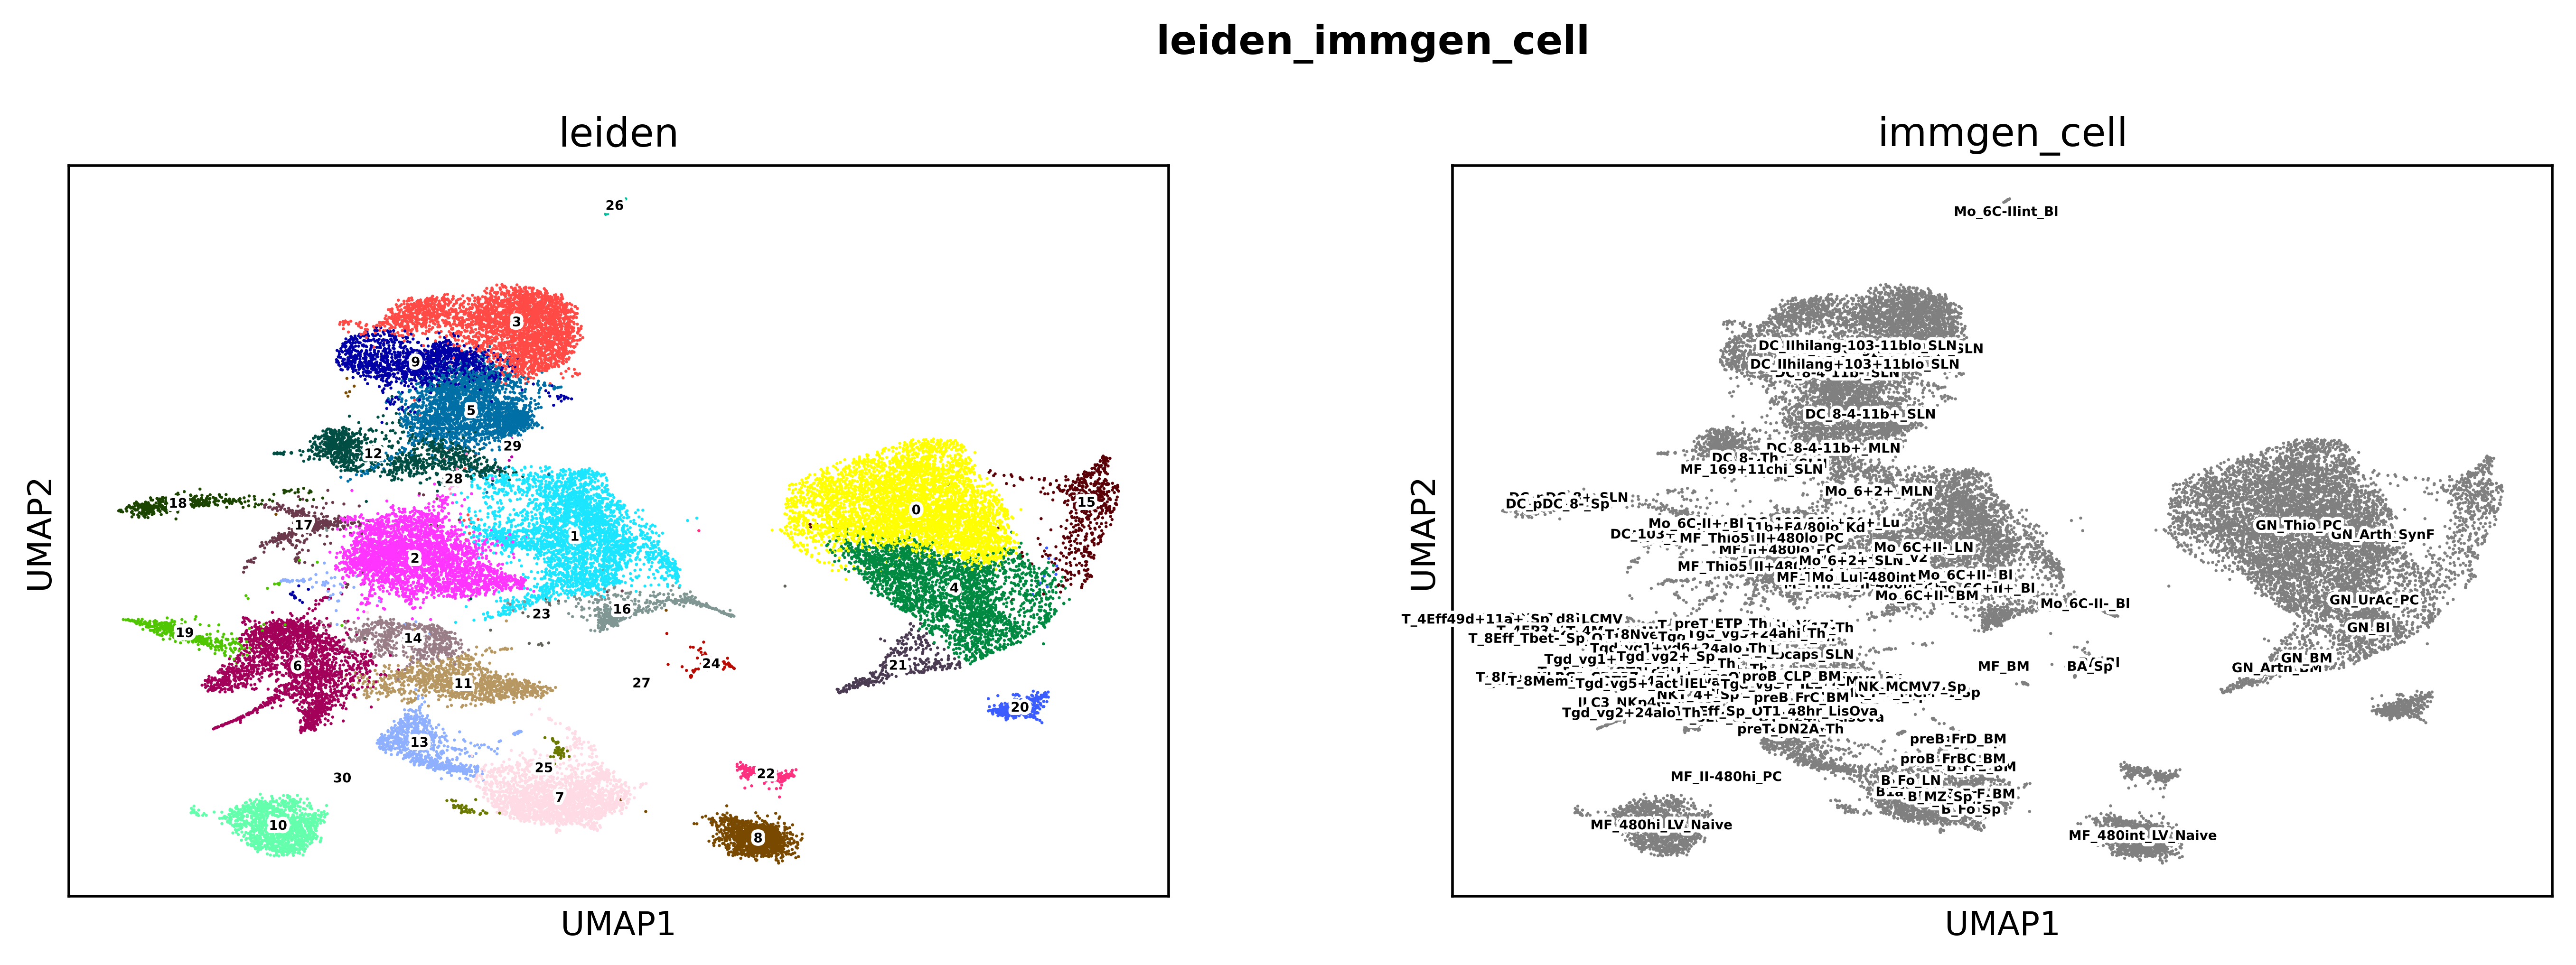

In [139]:
# Color each cell by MAP ImmGen class 
ng.umap_plot(adata, color=['leiden', 'immgen_cell'], return_fig=True, save_fig=False,  legend_fontsize = 4)

figures/leiden_immgen_leiden_200421_15h25_1.pdf done!


[<Figure size 6870x2000 with 2 Axes>]

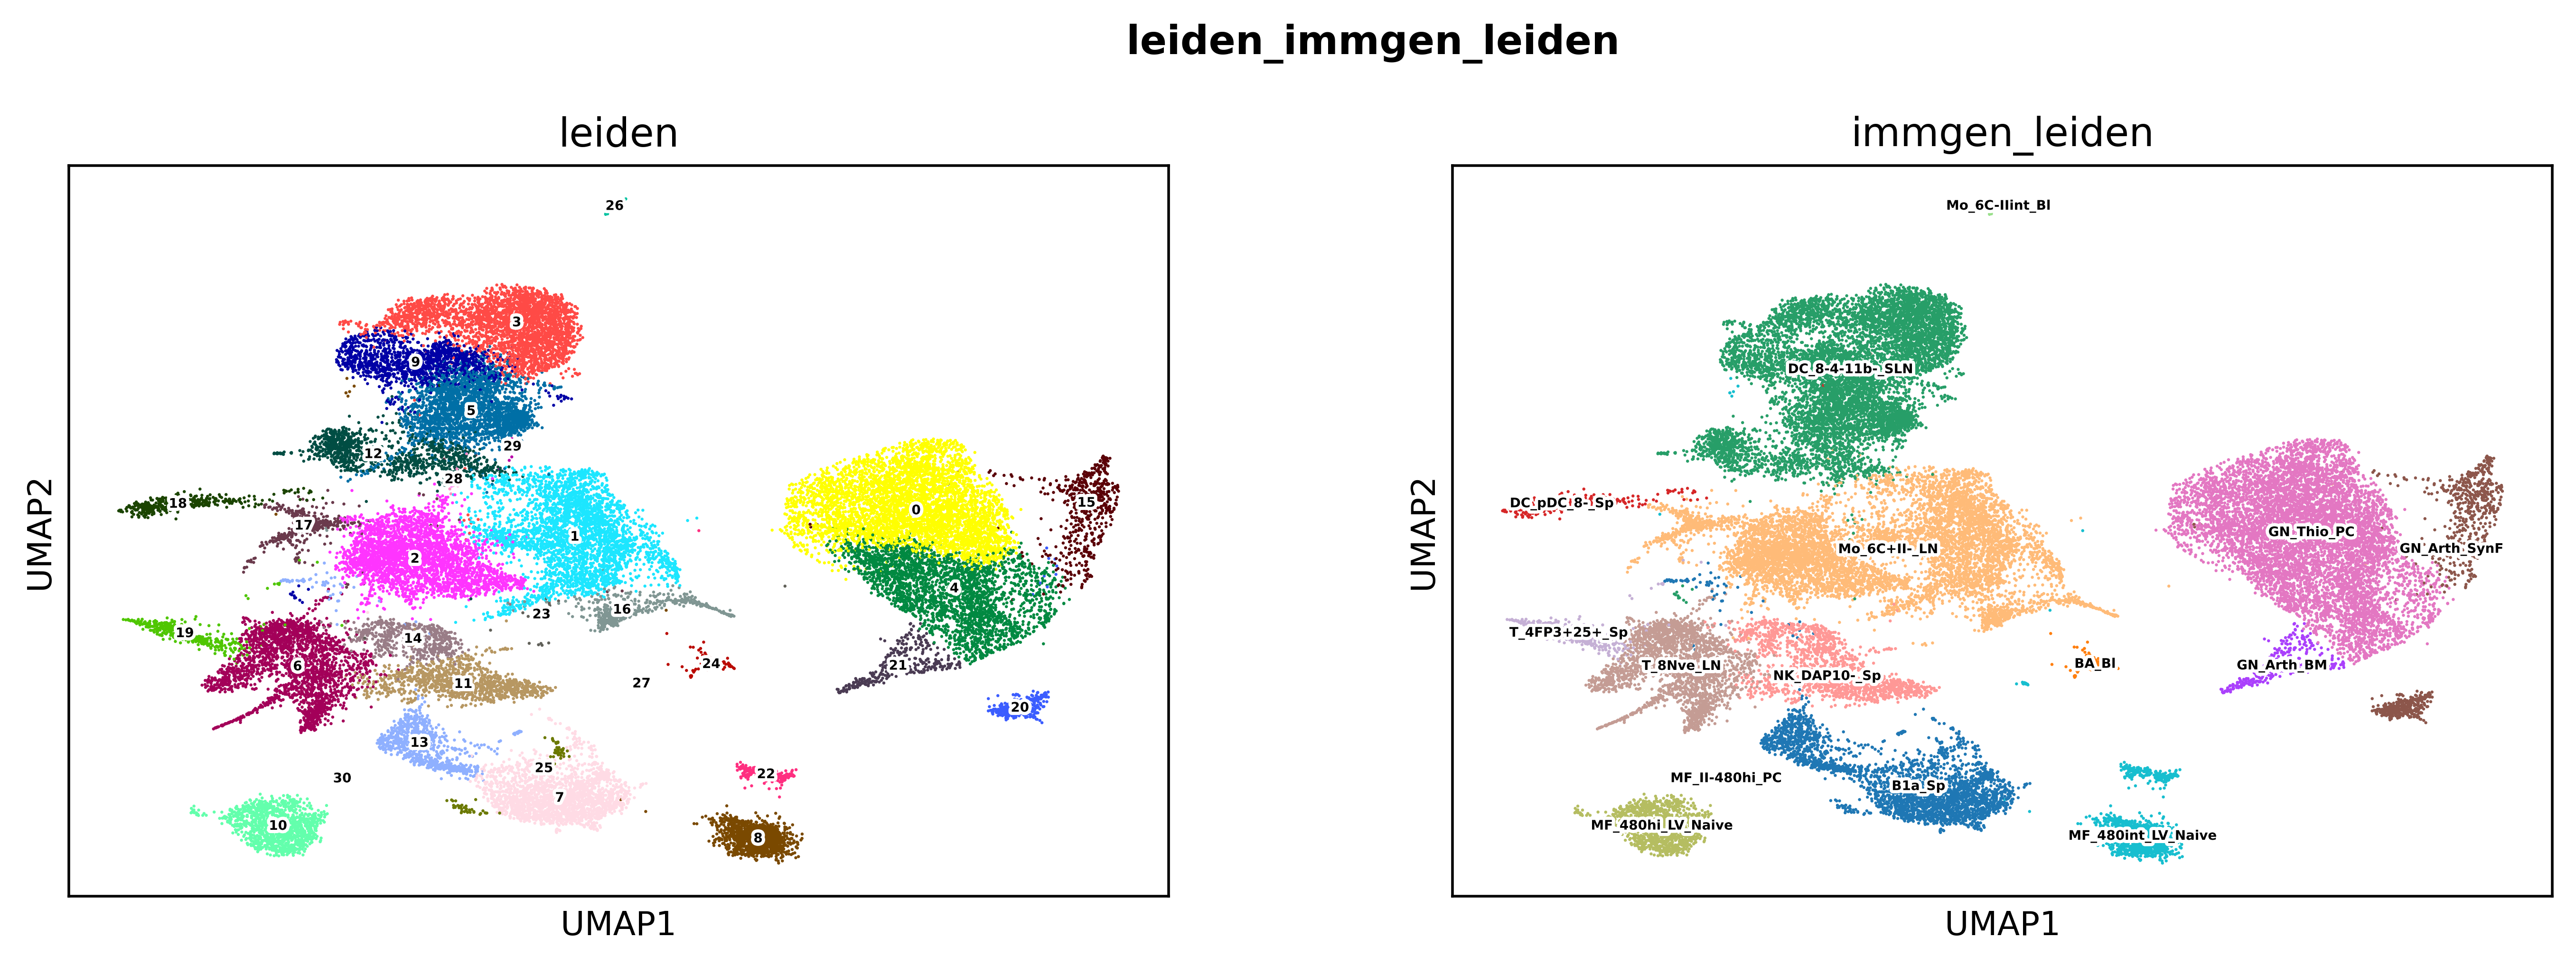

In [141]:
# Color each Leiden Cluster by MAP ImmGen class 
ng.umap_plot(adata, color=['leiden', 'immgen_leiden'],return_fig=True, save_fig=True,  legend_fontsize = 4)

In [ ]:
#DC_8-4-11b-SLN —> Skin Draining LN Triple Negative Dendritic Cell
#DC_pDC_8-_Sp —> Spleen CD8- Plasmacytoid Dendritic Cell
#Mo_6C+II-_LN —> Classical Monocytes, MHCII-
#BA_BI —> Blood Basophil
#GN_Thio_PC —> Neutrophils, Thioglycolate
#GN_Arth_SynF —> Neutrophils, Synovial Fluid
#GN_Arth_BM —> Neutrophils, Arthritic
#T_4FP3+25+_Sp —> SplCD25+Tregs
#T_8Nve_LN —> Subcutaneous LN Naive CD8
#NK_DAP10-_SP —> Splenic Natural Killer Cells
#MF_480_hi_LV_Naive —> F480hi Liver macrophage
#MF_480int_LV_Naive —> F480 int Liver macrophage
#MF_II_480hi_PC —> Peritoneal MF Steady State
#B1a_Sp —> B-1a B-cells


figures/tissue_Liver_treatment_Trx_by_leiden_immgen_leiden_200421_15h56_1.pdf done!
figures/tissue_Liver_treatment_NT_by_leiden_immgen_leiden_200421_15h56_2.pdf done!
figures/tissue_Tumor_treatment_Trx_by_leiden_immgen_leiden_200421_15h56_3.pdf done!
figures/tissue_Tumor_treatment_NT_by_leiden_immgen_leiden_200421_15h56_4.pdf done!


[<Figure size 6870x2000 with 2 Axes>,
 <Figure size 6870x2000 with 2 Axes>,
 <Figure size 6870x2000 with 2 Axes>,
 <Figure size 6870x2000 with 2 Axes>]

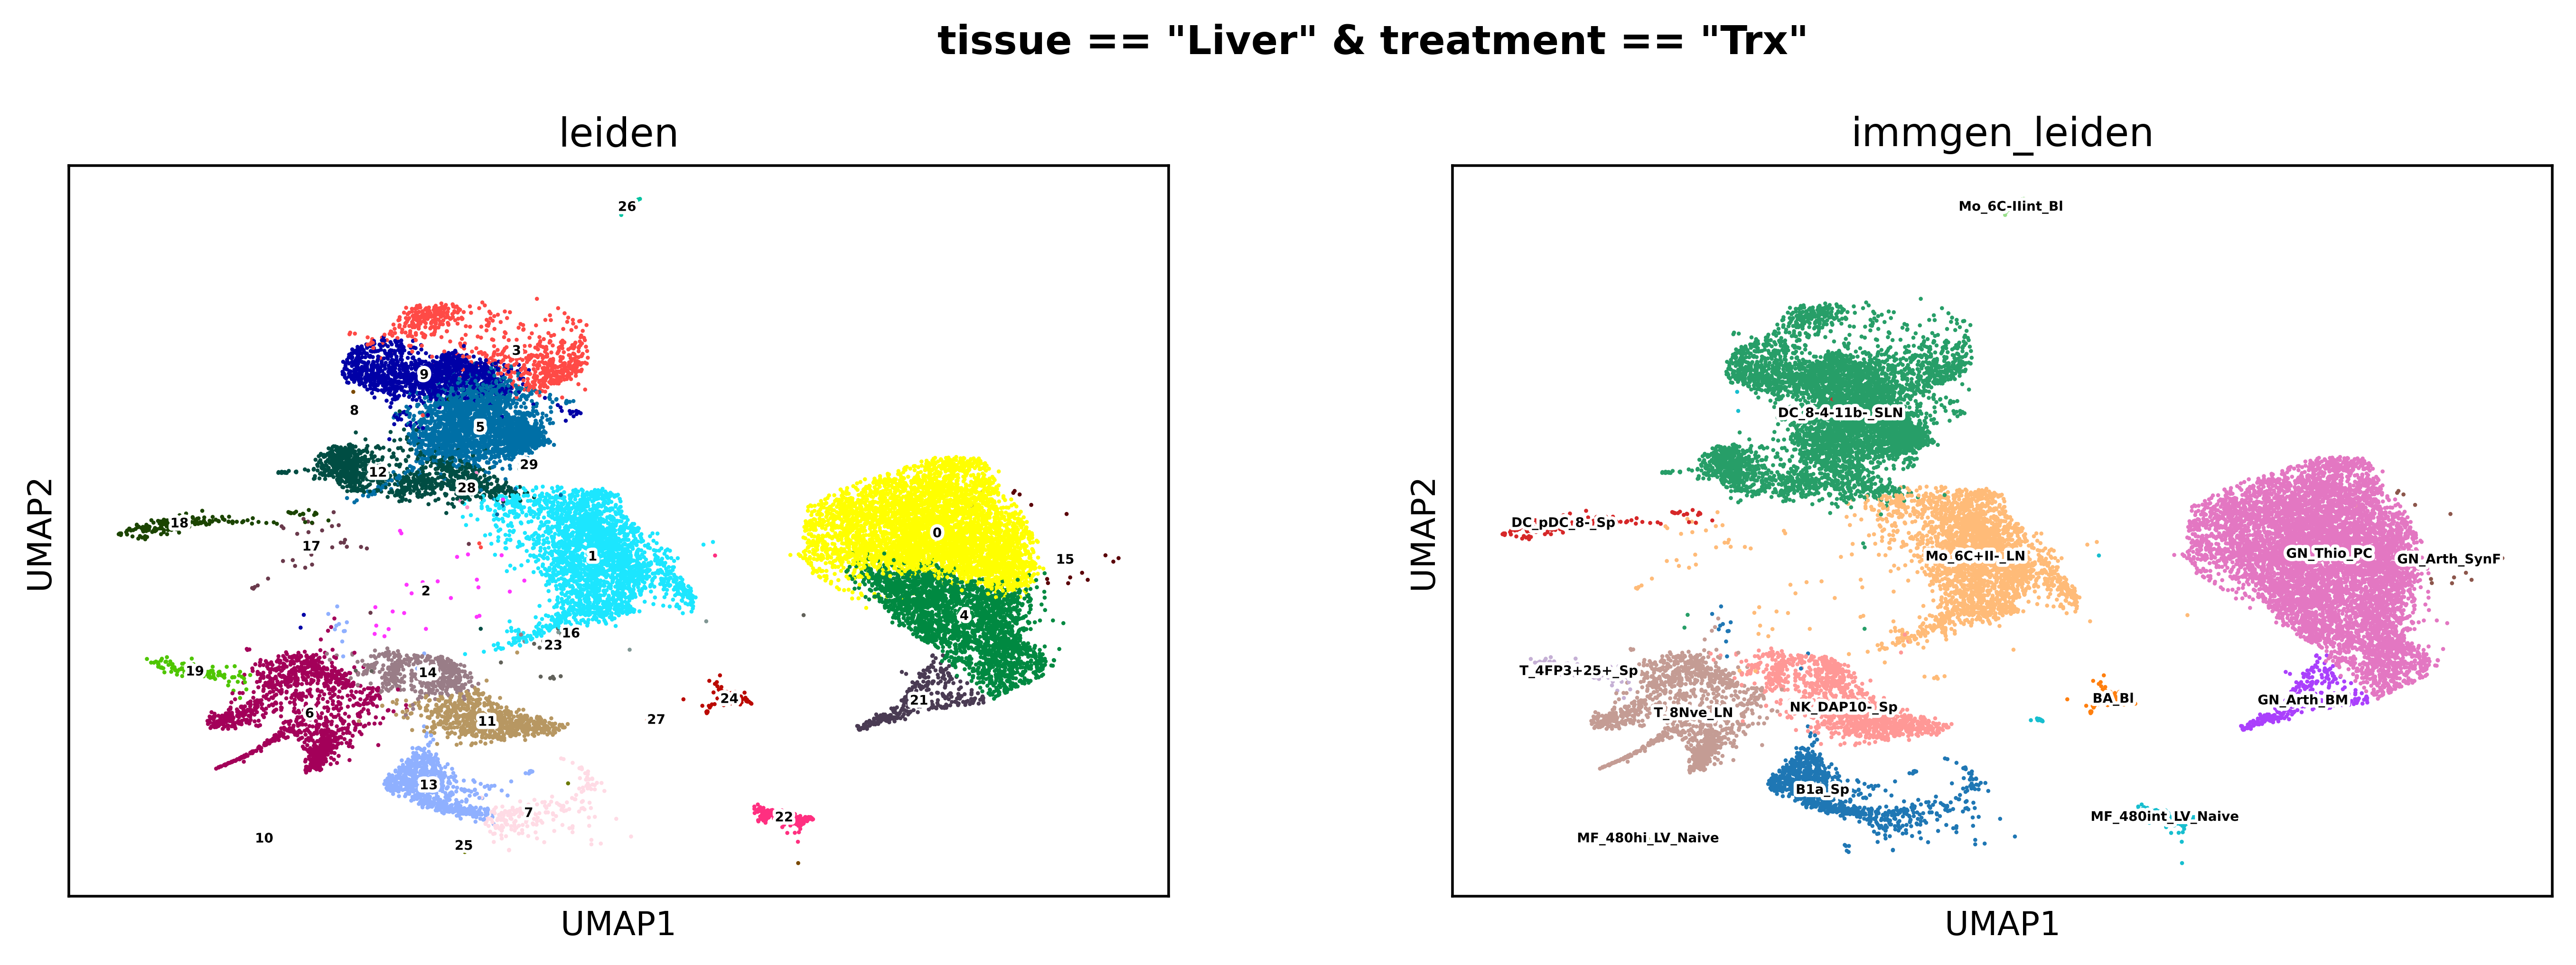

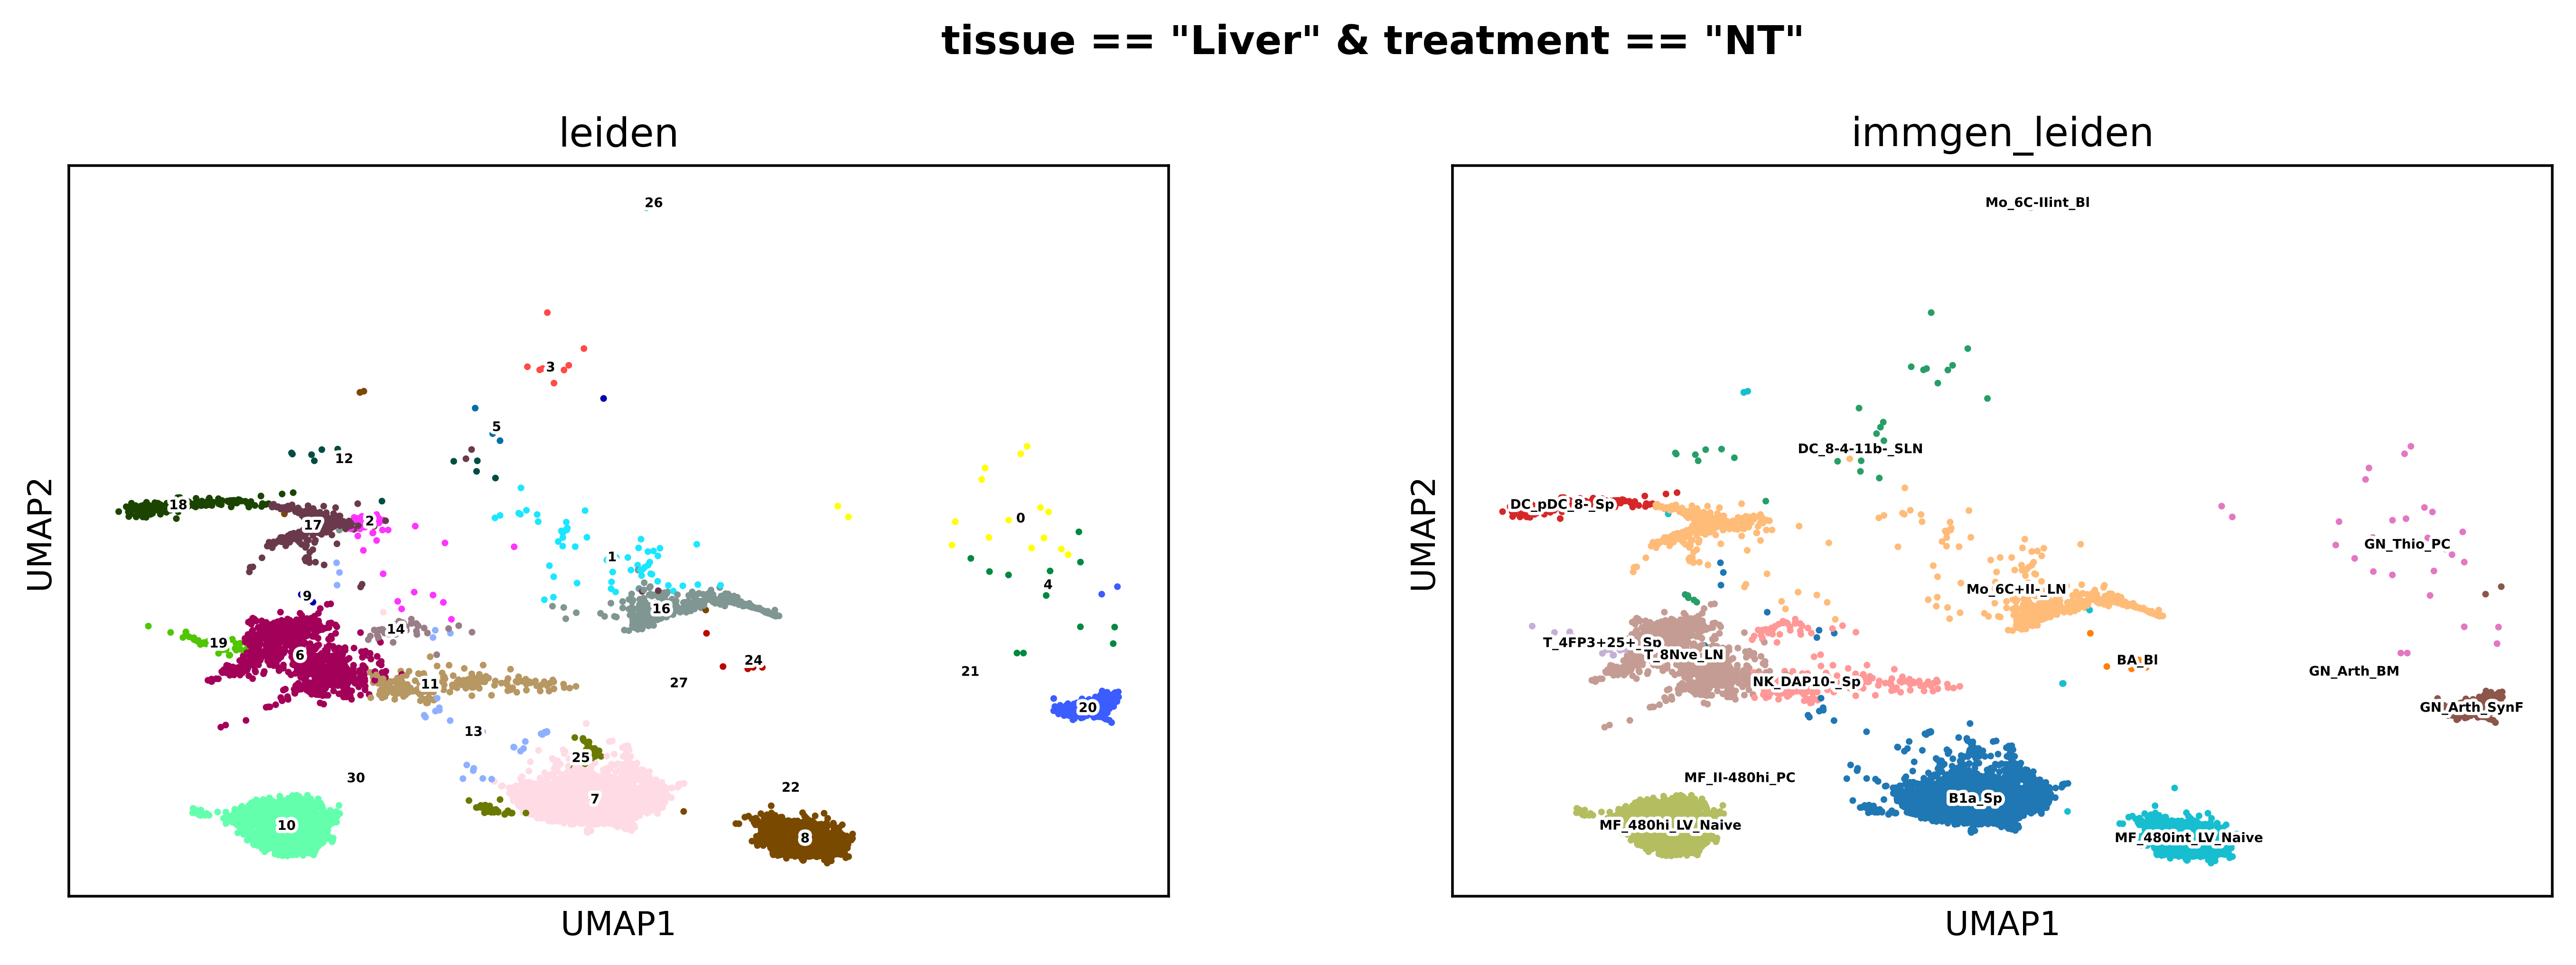

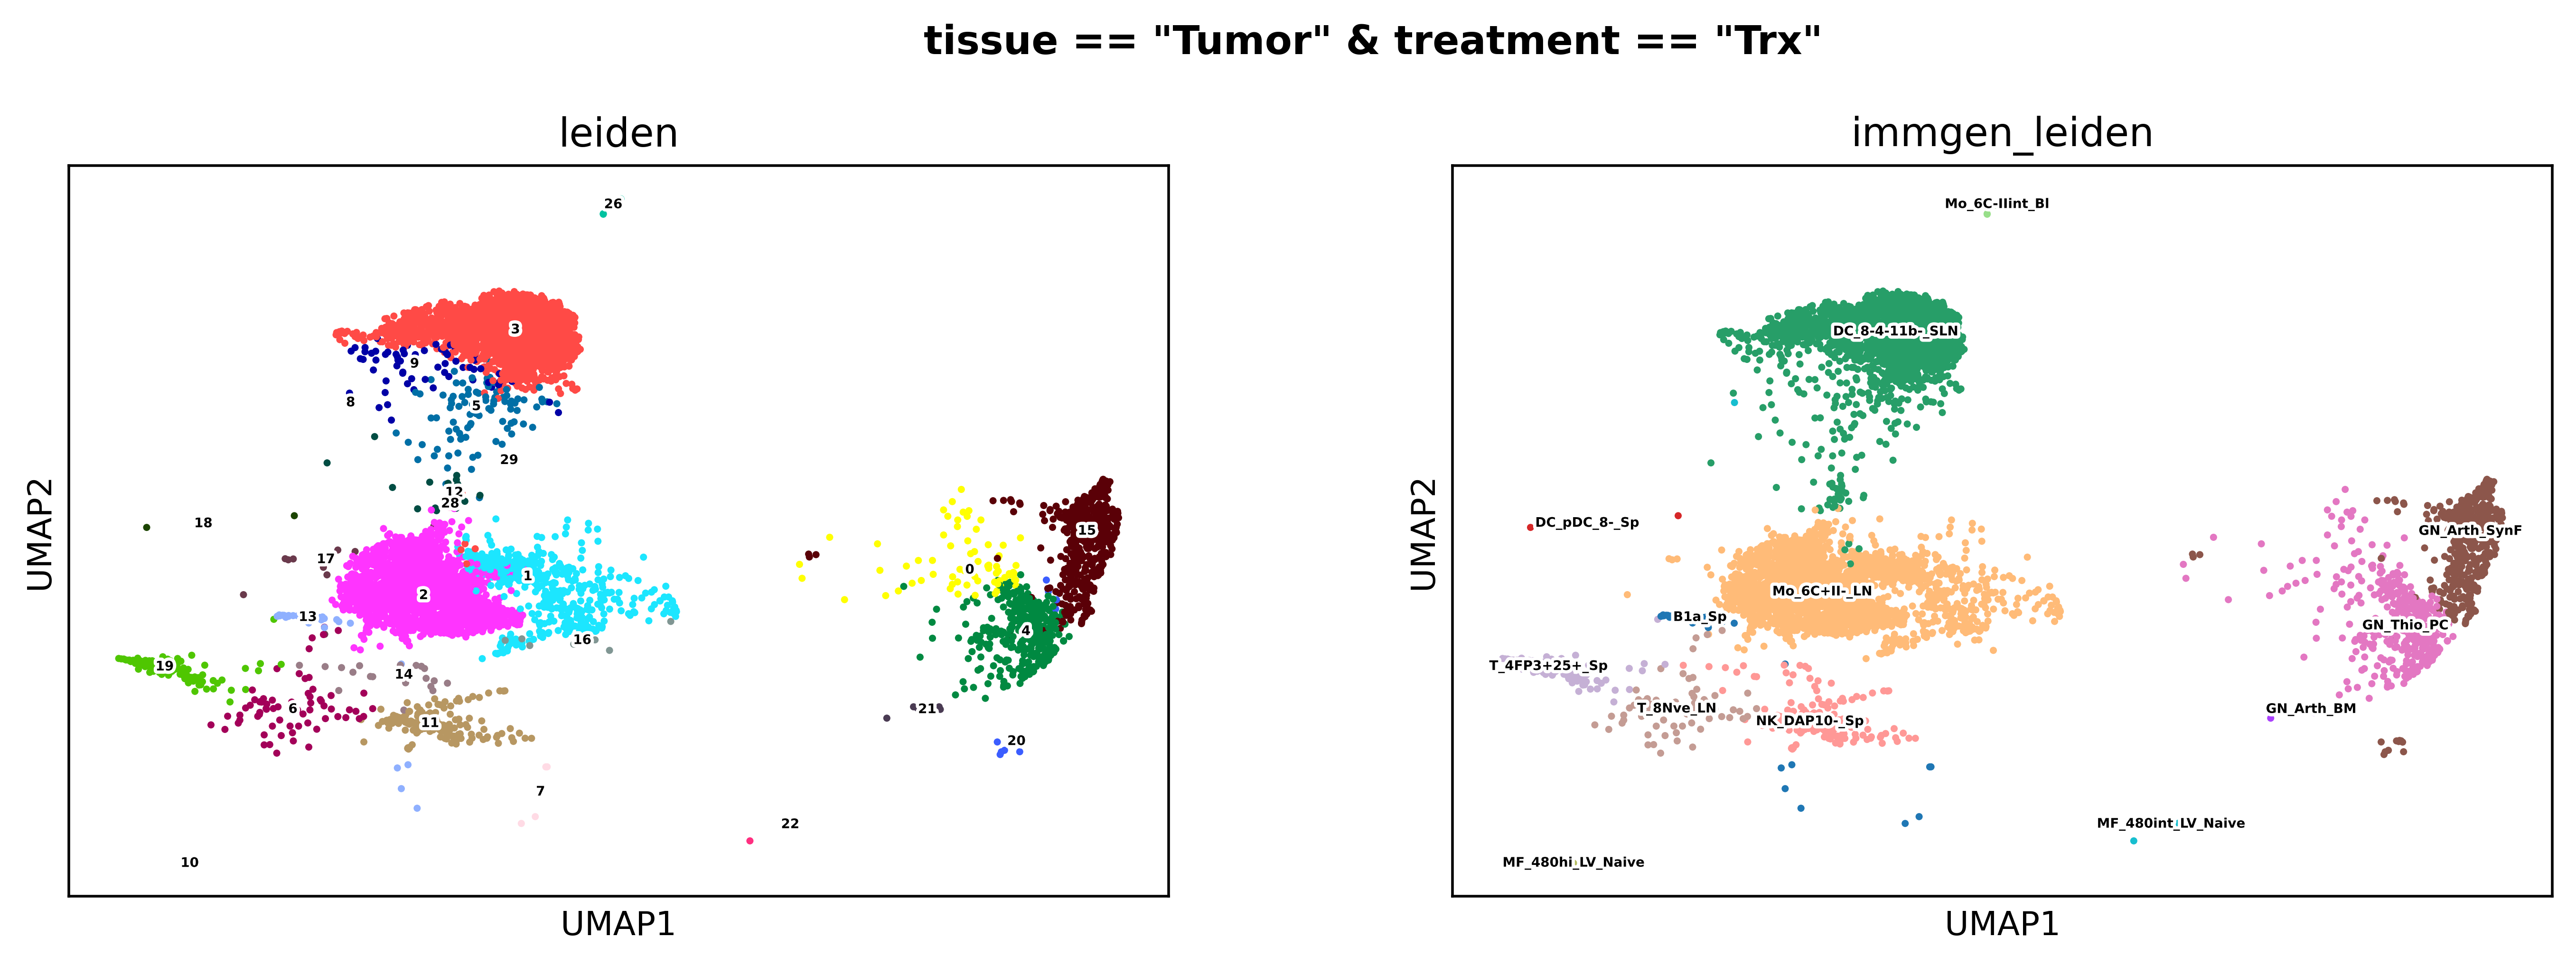

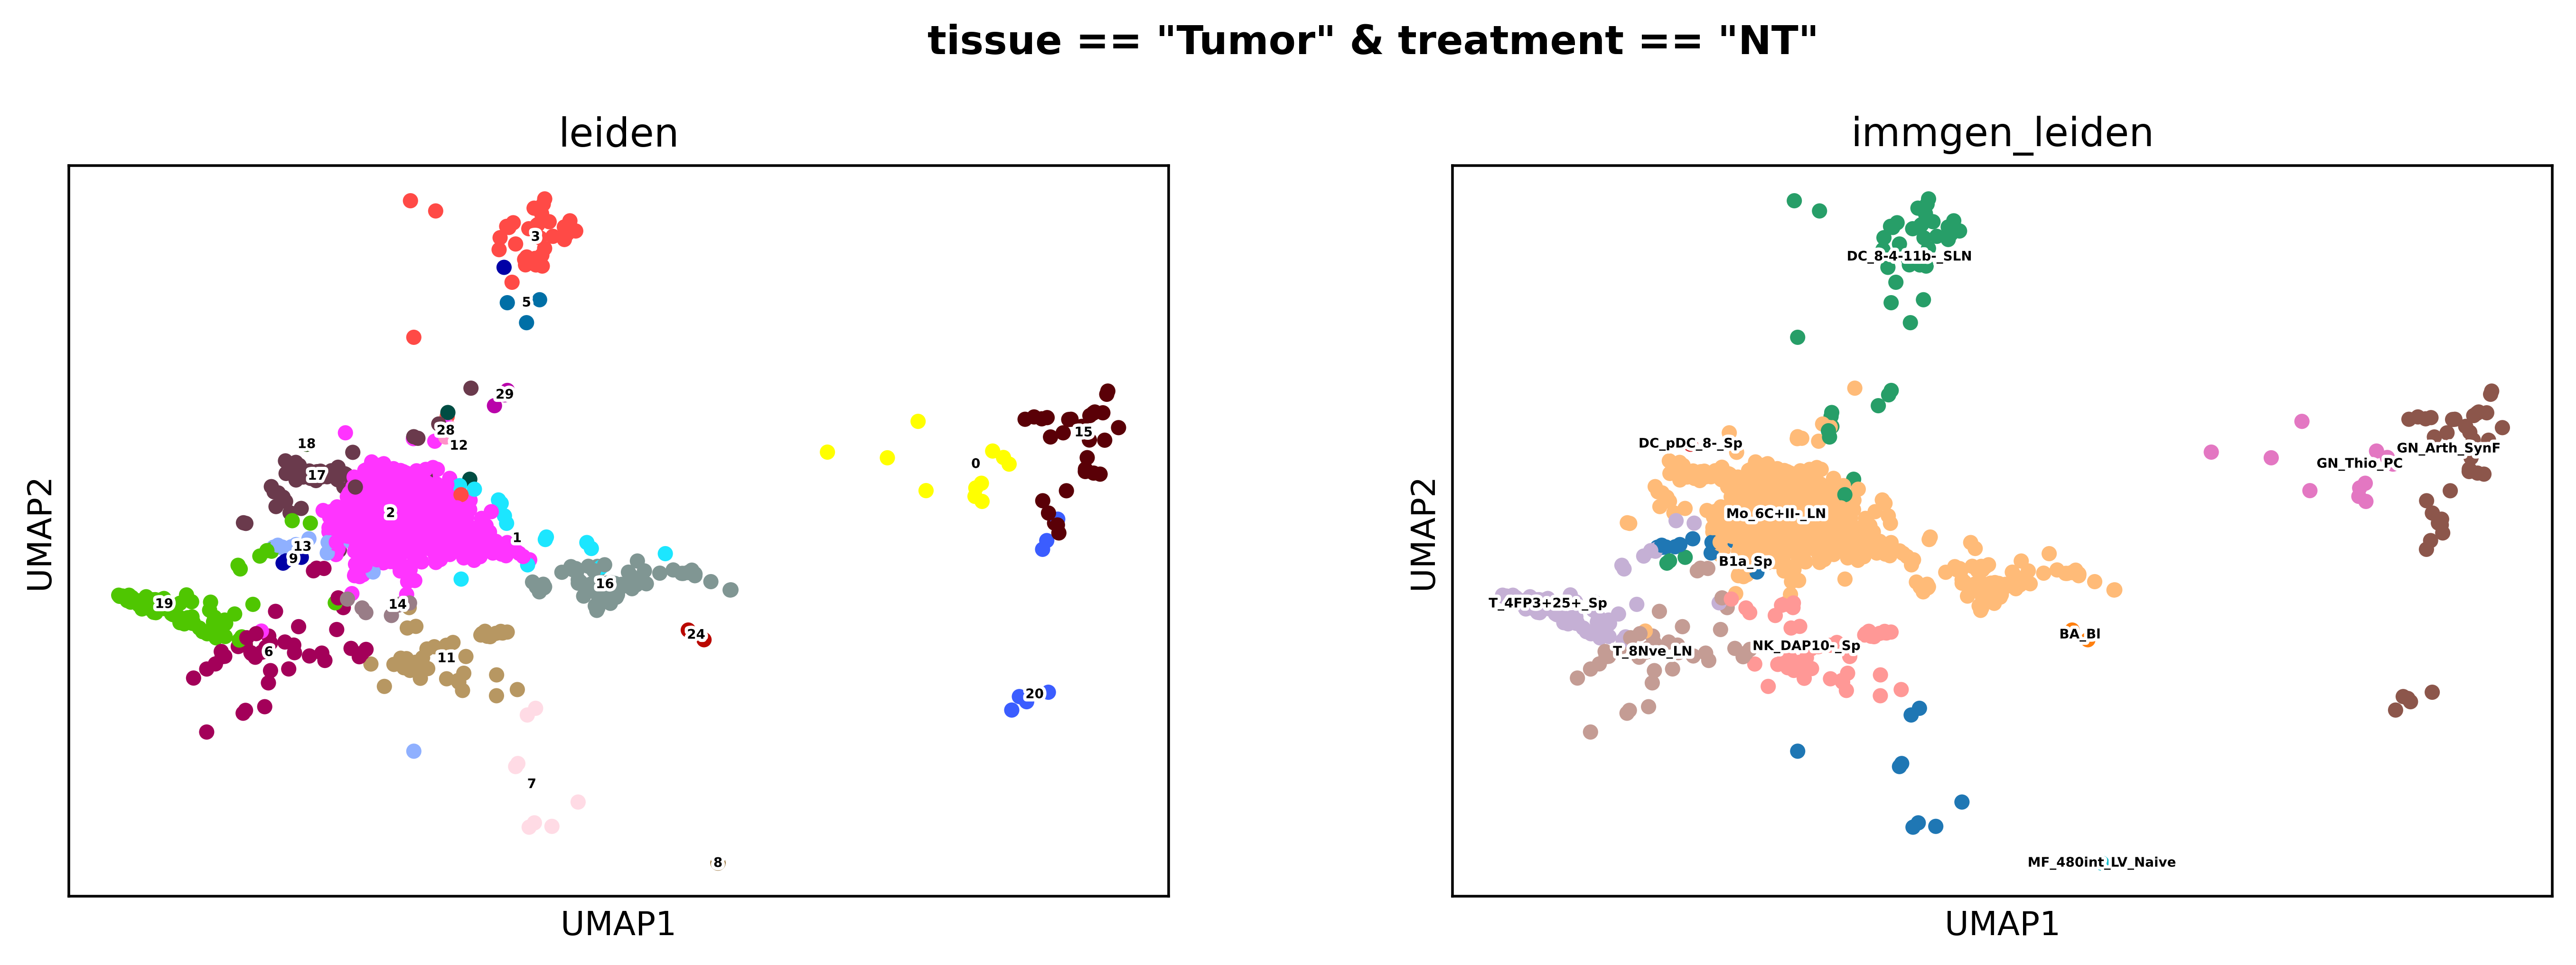

In [142]:
# Color each Leiden Cluster by MAP ImmGen class 
ng.umap_plot(adata, color=['leiden', 'immgen_leiden'], split_by_cats=['tissue', 'treatment'], return_fig=True, save_fig=True,  legend_fontsize = 4)